# Data Representation

- What does the data look like
- What are some ways to represent this data
- What is NER
- Wha

In [1]:
with open("data/data.txt") as f:
    data = f.read().strip().split("\n")


In [2]:
data[:5]

['Cortex Auth Issues',
 'Stack Driver NAT Approaching Capacity',
 'Logs Production Authentication Issues',
 'alerting bypass dspermissions',
 'loki-prod3 write outage']

<BarContainer object of 10 artists>

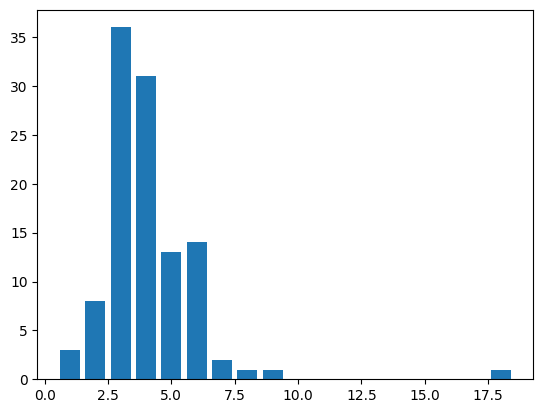

In [3]:
# get distribution of data length
from collections import Counter
from matplotlib import pyplot as plt

word_len_count = Counter([len(x.split()) for x in data])

plt.bar(word_len_count.keys(), word_len_count.values())

In [4]:
# get distribution of words

word_count = Counter([word for x in data for word in x.split()])

word_count.most_common(15)

[('HG', 12),
 ('to', 11),
 ('Loki', 10),
 ('Alertmanager', 8),
 ('us-central1', 8),
 ('outage', 7),
 ('in', 7),
 ('not', 7),
 ('prod', 7),
 ('Issues', 6),
 ('Grafana', 6),
 ('prod-us-central-0', 6),
 ('Tempo', 6),
 ('Cortex', 5),
 ('failing', 5)]

In [5]:
# get distribution of words without stopwords

with open("data/stopwords.txt") as f:
    stopwords = f.read().strip().split("\n")

word_count = Counter([word for x in data for word in x.split() if word not in stopwords])

word_count.most_common(15)

[('HG', 12),
 ('Loki', 10),
 ('Alertmanager', 8),
 ('us-central1', 8),
 ('outage', 7),
 ('prod', 7),
 ('Issues', 6),
 ('Grafana', 6),
 ('prod-us-central-0', 6),
 ('Tempo', 6),
 ('Cortex', 5),
 ('failing', 5),
 ('Failures', 4),
 ('SM', 4),
 ('ops', 4)]

# Named Entity Recognition

Named Entity Recognition (NER) is a machine learning technique used to identify and classify named entities in text. To put simply the model will be tasked to recognize a few different type of keywords.

In this case, we want to recognize services and environments related entities.

The input is a string, the output (aka target) is the span where the entities exist.

For example:

Text:
load balancer down in production-3

Target:

(0, 2, SERVICE)

(4, 5, ENVIRONMENT)

## Model training

How does model training work?

- present inputs and the related targets to the model
- ask the model to reproduce the tasks
- evaluate how the model is performing
- repeat until the model is sufficiently good at the task

# Data Representation

### How do we represent the text input to feed into the model?

1. Tokenization: break a string into "reasonable" substring

2. Encoding: map a token sequence into a integer id sequence

The simplest way to make tokens is to use words, most modern models may break down some words into multiple token. But when we think about tokens, we can roughly think of them as words.

In [6]:
# simple tokenizer

import re

def simple_tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

simple_token = simple_tokenizer("Hello, world! Hello, This is a test. Is this a test?")
print(f"Tokenized input: {simple_token}")

# token to id dict
id_to_token = {i: token for i, token in enumerate(set(simple_token))}
token_to_id = {token: i for i, token in id_to_token.items()}

print("Encoding dictionaries:\n", id_to_token)
print(token_to_id)

simple_id = [token_to_id[token] for token in simple_token]
print(f"Final input representation: {simple_id}")

Tokenized input: ['hello', 'world', 'hello', 'this', 'is', 'a', 'test', 'is', 'this', 'a', 'test']
Encoding dictionaries:
 {0: 'hello', 1: 'test', 2: 'this', 3: 'world', 4: 'a', 5: 'is'}
{'hello': 0, 'test': 1, 'this': 2, 'world': 3, 'a': 4, 'is': 5}
Final input representation: [0, 3, 0, 2, 5, 4, 1, 5, 2, 4, 1]


### How do we represent the output for an NER task?

We could represent it using the format above. A tuple of the format `(start, end, type)`, e.g. `(0, 2, SERVICE)`

This format is great for storage and evaluating correctness.

However, we don't actually know how many spans will be in the output at input time. So we need to design the model to accommodate an arbitrary number of outputs.


An alternative way is to map each token to a values. This way we can ask the model to just make one prediction for every token.

This is often done using the BIO (Beginning Inside Outside) format. We will label the first token of each span of interest with `B-<label>` any subsequent tokens with `I-<label>`. Any irrelevant tokens gets the `O` label

In our case, we are trying to predict Services (SERVICE) and Environments (ENVIRONMENT).

In [7]:
# Text: load balancer down in production-3

label = [
    "B-SERVICE",  # load
    "I-SERVICE",  # balancer
    "O",      # down
    "O",      # in
    "B-ENVIRONMENT",  # production-3
]